## Task 1: Data Understanding and Visualization:
1. Load and visualize images from a dataset stored in directories, where each subdirectory represents a class.

In [1]:
dataset_path= "C:/Users/Admin/OneDrive/Desktop/JUPYTER/FruitinAmazon"

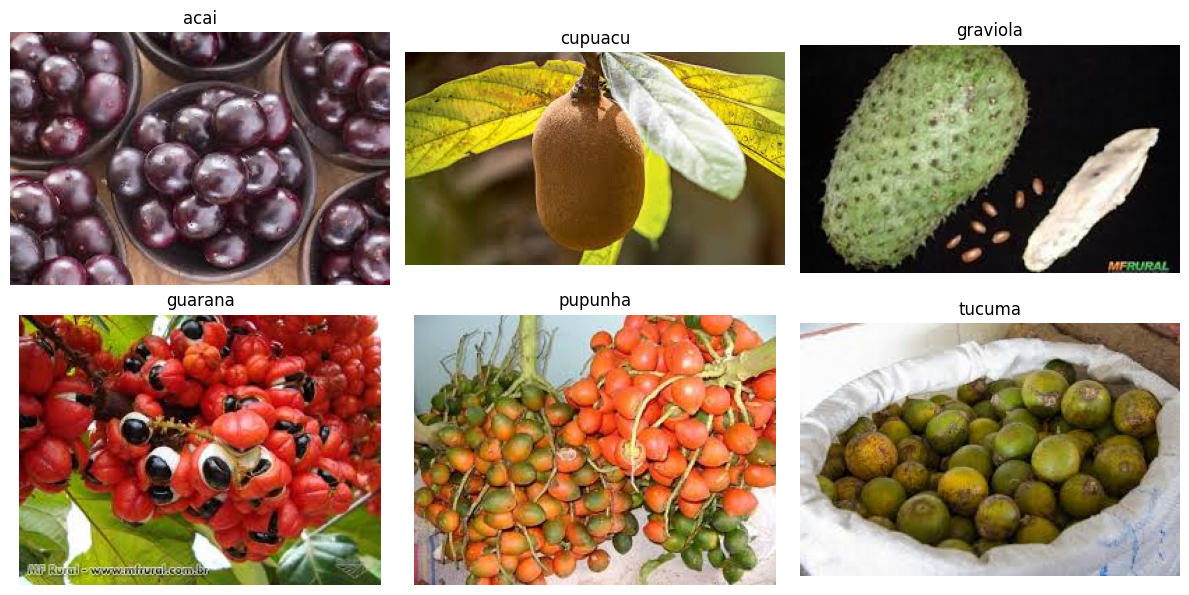

In [27]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

train_dir = "C:/Users/Admin/OneDrive/Desktop/JUPYTER/FruitinAmazon/train"
test_dir = "C:/Users/Admin/OneDrive/Desktop/JUPYTER/FruitinAmazon/test"

#List of class Directories
fruit_classes = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

#select one random image from each fruit class
selected_images = []
for fruit in fruit_classes:
    fruit_path = os.path.join(train_dir, fruit)
    images = os.listdir(fruit_path)
    if images:
        random_image = random.choice(images)
        selected_images.append((fruit, os.path.join(fruit_path, random_image)))

num_classes = len(selected_images)
nrows = 2
ncols = (num_classes + 1) // 2

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 6))
axes = axes.flatten()

#plot
for ax, (label, img_path) in zip(axes, selected_images):
    img = mpimg.imread(img_path)
    ax.imshow(img)
    ax.set_title(label)
    ax.axis("off")

for ax in axes[len(selected_images):]:
    ax.axis("off")

plt.tight_layout()
plt.show()


What did you observe?


The script scans the train directory and lists all subdirectories (each representing a fruit category).
It randomly selects one image from each fruit category.The code calculates how many rows and columns are needed to display the images.
The grid has two rows and a dynamically calculated number of columns. Uses plt.subplots() to create a grid.
Each selected image is displayed with its fruit category as the title.
Any extra empty grid spaces are turned off to keep the visualization clean.


Check for Corrupted Image
**bold text**





In [3]:
import os
from PIL import Image

fruit_classes = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

corrupted_images = []

for fruit in fruit_classes:
    fruit_path = os.path.join(train_dir, fruit)
    images = os.listdir(fruit_path)

    for image in images:
        image_path = os.path.join(fruit_path, image)
        try:
            with Image.open(image_path) as img:
                img.verify()  # Verify if the image is valid
        except (IOError, SyntaxError):
            os.remove(image_path)  # Remove corrupted image
            corrupted_images.append(image_path)
            print(f"Removed corrupted image: {image_path}")

if not corrupted_images:
    print("No Corrupted Images Found.")


No Corrupted Images Found.


## Task 2: Loading and Preprocessing Image Data in Keras

In [4]:
import tensorflow as tf
# Define image size and batch size
img_height = 128 # Example image height
img_width = 128 # Example image width
batch_size = 32
validation_split = 0.2
# Create a preprocessing layer for normalization
rescale = tf.keras.layers.Rescaling(1./255) # Normalize pixel values to [0, 1]
# Create training dataset with normalization
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
train_dir,
labels="inferred",
label_mode="int",
image_size=(img_height, img_width),
interpolation="nearest",
batch_size=batch_size,
shuffle=True,
validation_split=validation_split,
subset="training",
seed=123
)
# Apply the normalization (Rescaling) to the dataset
train_ds = train_ds.map(lambda x, y: (rescale(x), y))
# Create validation dataset with normalization
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
train_dir,
labels="inferred",
label_mode="int",
image_size=(img_height, img_width),
interpolation="nearest",
batch_size=batch_size,
shuffle=False,
validation_split=validation_split,
subset="validation",
seed=123
)
# Apply the normalization (Rescaling) to the validation dataset
val_ds = val_ds.map(lambda x, y: (rescale(x), y))

Found 90 files belonging to 6 classes.
Using 72 files for training.
Found 90 files belonging to 6 classes.
Using 18 files for validation.


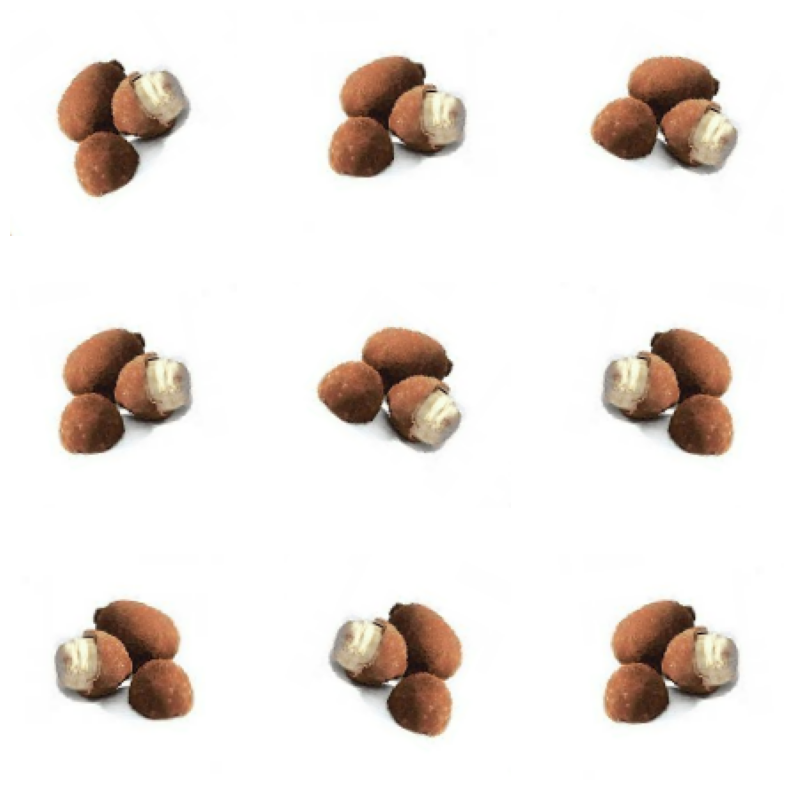

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import layers

data_augmentation_layers = [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
]

def data_augmentation(images):
    for layer in data_augmentation_layers:
        images = layer(images)
    return images

plt.figure(figsize=(10, 10))

for images, _ in train_ds.take(1):  # Assumes 'train_ds' is your dataset
    for i in range(9):
        augmented_images = data_augmentation(images)
        augmented_image = augmented_images[0].numpy()  # Convert tensor to NumPy array
        augmented_image = np.clip(augmented_image * 255, 0, 255).astype("uint8")  # Scale and clip to 0-255 range
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_image)
        plt.axis("off")

plt.show()


## Task 3

## Fully Connected Network Architecture:

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the CNN model
model = models.Sequential([
    layers.Lambda(data_augmentation, input_shape=(224, 224, 3)),
    layers.Rescaling(1./255),
    
    # Convolutional Layer 1
    layers.Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding="same", activation="relu", input_shape=(128, 128, 3)),
    layers.BatchNormalization(),
    # Pooling Layer 1
    layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    layers.Dropout(0.25),

    # Convolutional Layer 2
    layers.Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding="same", activation="relu"),
    layers.BatchNormalization(),
    # Pooling Layer 2
    layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    layers.Dropout(0.25),

    # Convolutional Layer 3
    layers.Conv2D(filters=32, kernel_size=(3, 3), strides=1, padding="same", activation="relu"),
    layers.BatchNormalization(),
    # Pooling Layer 3
    layers.MaxPooling2D(pool_size=(2, 2), strides=2),
    layers.Dropout(0.25),

    # Flatten Layer
    layers.Flatten(),

    # Adjusting the first Dense layer input size based on output shape
    layers.Dense(8192, activation=None),  # Adjusted input size based on the output of Flatten()
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),

    # Second Fully Connected Layer
    layers.Dense(256, activation=None),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),

    # Third Fully Connected Layer
    layers.Dense(128, activation=None),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),

    # Fourth Fully Connected Layer
    layers.Dense(64, activation=None),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Dropout(0.5),

    # Output Layer with 10 neurons (for classification task with 10 classes)
    layers.Dense(10, activation='softmax')
])

# Print model summary
model.summary()

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\lambda_layer.py:65: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                      │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling_1 (Rescaling)              │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 224, 224, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 112, 112, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 112, 112, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 56, 56, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 56, 56, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 56, 56, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 28, 28, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 8192)                │     205,529,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 8192)                │          32,768 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 207,722,634 (792.40 MB)

 Trainable params: 207,705,162 (792.33 MB)

 Non-trainable params: 17,472 (68.25 KB)

**Task 4: Compile the Model**

Model Compilation


In [7]:
# Compile the model
model.compile(
    # sgd optimizer
    optimizer='sgd',
     # Loss function for multi-class classification with integer labels
    loss='sparse_categorical_crossentropy',
     # Metric to evaluate the model during training
    metrics=['accuracy']
)


### Train the Model

In [9]:
import tensorflow as tf

# Define number of classes
num_classes = 10  # Change this to match your dataset

# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),  # Automatically adapts to the correct shape
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',  # Use 'categorical_crossentropy' if labels are one-hot encoded
    metrics=['accuracy']
)

# Define the callbacks
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    'fruit_model.keras',  # Save the model in .keras format
    monitor='val_loss',  # Monitor validation loss
    save_best_only=True,  # Save only the best model
    mode='min',  # 'min' because we want to minimize the loss
    verbose=1  # Print a message when saving the best model
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=10,  # Stop after 10 epochs with no improvement
    mode='min',  # Stop when validation loss stops decreasing
    verbose=1  # Print a message when stopping early
)

# Train the model using the fit() method
history = model.fit(
    train_ds,  # The training dataset
    epochs=250,  # Number of epochs
    validation_data=val_ds,  # Validation dataset
    callbacks=[checkpoint_callback, early_stopping_callback],  # Callbacks
    verbose=2  # Print detailed progress for each epoch
)


Epoch 1/250

Epoch 1: val_loss improved from inf to 1.77202, saving model to fruit_model.keras
3/3 - 8s - 3s/step - accuracy: 0.1528 - loss: 2.1721 - val_accuracy: 0.8333 - val_loss: 1.7720
Epoch 2/250

Epoch 2: val_loss did not improve from 1.77202
3/3 - 1s - 281ms/step - accuracy: 0.3611 - loss: 1.8641 - val_accuracy: 0.3889 - val_loss: 1.9298
Epoch 3/250

Epoch 3: val_loss improved from 1.77202 to 1.44658, saving model to fruit_model.keras
3/3 - 1s - 405ms/step - accuracy: 0.3194 - loss: 1.5993 - val_accuracy: 0.7222 - val_loss: 1.4466
Epoch 4/250

Epoch 4: val_loss improved from 1.44658 to 1.31355, saving model to fruit_model.keras
3/3 - 1s - 356ms/step - accuracy: 0.6806 - loss: 1.2444 - val_accuracy: 0.6667 - val_loss: 1.3136
Epoch 5/250

Epoch 5: val_loss improved from 1.31355 to 0.78208, saving model to fruit_model.keras
3/3 - 1s - 318ms/step - accuracy: 0.6389 - loss: 1.0205 - val_accuracy: 0.6111 - val_loss: 0.7821
Epoch 6/250

Epoch 6: val_loss did not improve from 0.78208
3

## Task 5: Model Evaluation

In [10]:
# Evaluate the model on the test dataset
# Assuming val_ds is used as the test set
test_loss, test_accuracy = model.evaluate(val_ds)

# Print test results
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 917ms/step - accuracy: 0.8333 - loss: 0.4442
Test Accuracy: 83.33%
Test Loss: 0.4442


Task 6: Save and Load the Model
Model Saving and Loading

In [11]:
# Save the trained model properly
model.save("fruit_classification_model.h5", save_format="h5")
print("Model saved successfully.")


Model saved successfully.


In [12]:
# Reload the model
loaded_model = tf.keras.models.load_model("fruit_classification_model.h5")
print("Model loaded successfully.")

# Print model summary
loaded_model.summary()


Model loaded successfully.


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,932 (12.61 MB)

 Trainable params: 3,305,930 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

Load the saved model and re-evaluate its performance on the test set.

In [14]:
img_height = 128
img_width = 128
batch_size = 16

# Apply the same normalization as during training
rescale = tf.keras.layers.Rescaling(1./255)

# Load the test dataset
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "C:/Users/Admin/OneDrive/Desktop/JUPYTER/FruitinAmazon/test",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False  # No shuffling to match predictions with labels
)

# Normalize the test dataset
test_ds = test_ds.map(lambda x, y: (rescale(x), y))


Found 30 files belonging to 6 classes.


In [15]:
# Evaluate the model
test_loss, test_accuracy = loaded_model.evaluate(test_ds, verbose=2)

# Print test results
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4%}")


2/2 - 5s - 3s/step - accuracy: 0.7667 - loss: 1.2054
Test Loss: 1.2054
Test Accuracy: 76.6667%


Task 7: Predictions and Classification Report
Making Predictions

Model Prediction

In [16]:
import numpy as np

# Make predictions on the test dataset
predictions = loaded_model.predict(test_ds)

# Convert predicted probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step


Classification Report

In [17]:
from sklearn.metrics import classification_report
import numpy as np

# Load the test dataset without mapping to get class names
raw_test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "C:/Users/Admin/OneDrive/Desktop/JUPYTER/FruitinAmazon/test",
    image_size=(128, 128),
    batch_size=16,
    shuffle=False  # No shuffling to match predictions with labels
)

# Get class names from the dataset
class_names = raw_test_ds.class_names  # This works because raw_test_ds retains class names
print("Class Names:", class_names)

# Now, apply normalization again
test_ds = raw_test_ds.map(lambda x, y: (x / 255.0, y))

# Make predictions
predictions = loaded_model.predict(test_ds)

# Convert probabilities to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Extract true labels from the dataset
true_labels = np.concatenate([y.numpy() for _, y in test_ds])

# Generate classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names)
print("Classification Report:\n", report)


Found 30 files belonging to 6 classes.
Class Names: ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma']
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
Classification Report:
               precision    recall  f1-score   support

        acai       0.80      0.80      0.80         5
     cupuacu       0.60      0.60      0.60         5
    graviola       0.62      1.00      0.77         5
     guarana       0.83      1.00      0.91         5
     pupunha       1.00      0.80      0.89         5
      tucuma       1.00      0.40      0.57         5

    accuracy                           0.77        30
   macro avg       0.81      0.77      0.76        30
weighted avg       0.81      0.77      0.76        30



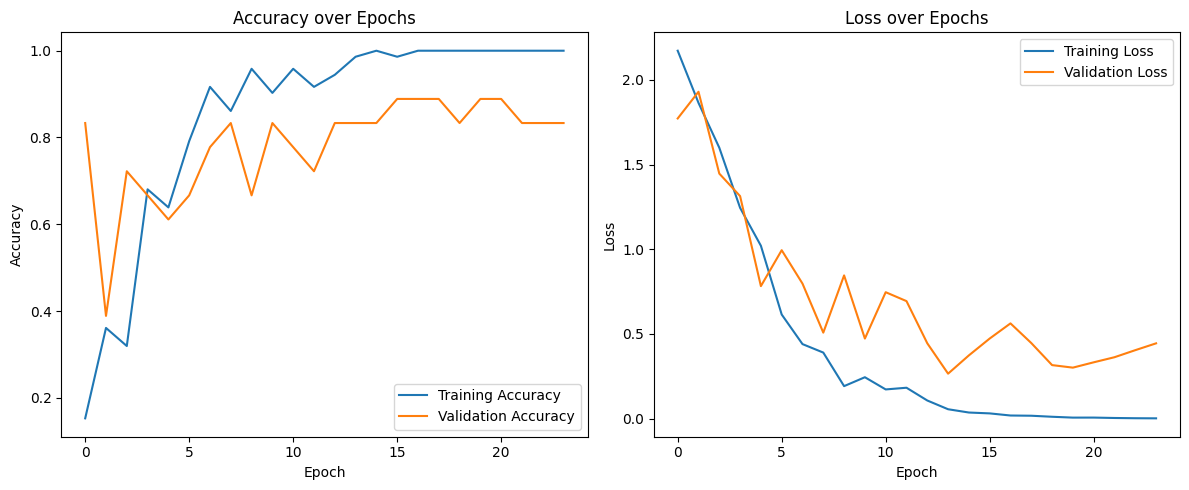

In [19]:
# Plot training & validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.tight_layout()
plt.show()

  Confusion Matrx

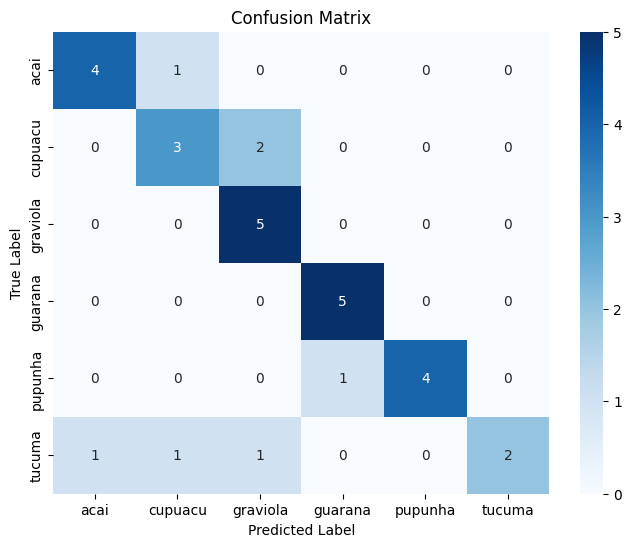

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix using seaborn
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [21]:
### Task 2

In [31]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Paths to training and testing directories
train_dir = "C:/Users/Admin/OneDrive/Desktop/JUPYTER/FruitinAmazon/train"
test_dir = "C:/Users/Admin/OneDrive/Desktop/JUPYTER/FruitinAmazon/test"

# Data preprocessing with rescaling
datagen = ImageDataGenerator(rescale=1./255)

# Load training data
train_data = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

# Load validation data
validation_data = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 90 images belonging to 6 classes.
Found 30 images belonging to 6 classes.


In [32]:
from tensorflow.keras.applications import VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


In [33]:
for layer in base_model.layers:
    layer.trainable = False

In [34]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(6, activation='softmax')(x)  # 6 classes

In [35]:
from tensorflow.keras.models import Model
model = Model(inputs=base_model.input, outputs=x)

In [36]:
from tensorflow.keras.optimizers import Adam
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_data, epochs=10, validation_data=validation_data)

C:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 96s 32s/step - accuracy: 0.1050 - loss: 1.9301 - val_accuracy: 0.3667 - val_loss: 1.6857
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 44s 18s/step - accuracy: 0.3510 - loss: 1.5976 - val_accuracy: 0.3333 - val_loss: 1.5813
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 65s 28s/step - accuracy: 0.6014 - loss: 1.3874 - val_accuracy: 0.4333 - val_loss: 1.4969
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 58s 26s/step - accuracy: 0.7124 - loss: 1.2033 - val_accuracy: 0.6333 - val_loss: 1.4046
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 30s 11s/step - accuracy: 0.7959 - loss: 1.0960 - val_accuracy: 0.5333 - val_loss: 1.3277
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 48s 19s/step - accuracy: 0.7605 - loss: 0.9550 - val_accuracy: 0.4333 - val_loss: 1.3170
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 57s 24s/step - accuracy: 0.8002 - loss: 0.8742 - val_accuracy: 0.4667 - val_loss: 1.3106
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 39s 14s/step - accuracy: 0.8444 - loss: 0.7600 - val_accuracy: 0.5667 - val_loss: 1.2713


In [37]:
from sklearn.metrics import classification_report

# Get predictions from the model
predictions = model.predict(validation_data)

# Since predictions are probabilities, we need to convert them to class labels
predicted_labels = predictions.argmax(axis=-1)

# Get the true labels from validation data
true_labels = validation_data.labels

# Print the classification report
print(classification_report(true_labels, predicted_labels))

1/1 ━━━━━━━━━━━━━━━━━━━━ 28s 28s/step
              precision    recall  f1-score   support

           0       0.20      0.20      0.20         5
           1       0.20      0.20      0.20         5
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         5
           4       0.00      0.00      0.00         5
           5       0.29      0.40      0.33         5

    accuracy                           0.13        30
   macro avg       0.11      0.13      0.12        30
weighted avg       0.11      0.13      0.12        30

